In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator

from joblib import dump
from typing import List, Dict, Tuple

from src.dataloader import DataLoader
from src.json_parser import JsonParser
import logging
logging.basicConfig(encoding='utf-8', level=logging.INFO)

### 1. Loading and processing data

Let us first download data. The following  runs the data extraction from the nvd.nist.gov site, unzips the files and stores to the `data` folder by default. 

In [2]:
dl = DataLoader(data_path_name = 'data')

In [3]:
# Generate URLs for the CVE files
urls = [f"https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{year}.json.zip" for year in range(2002, 2023)]

In [4]:
# Filenames of the stored files
filenames = dl.download_unzip_store_from_urls(urls)

INFO:root:Finished writing to nvdcve-1.1-2002.json
INFO:root:Finished writing to nvdcve-1.1-2003.json
INFO:root:Finished writing to nvdcve-1.1-2004.json
INFO:root:Finished writing to nvdcve-1.1-2005.json
INFO:root:Finished writing to nvdcve-1.1-2006.json
INFO:root:Finished writing to nvdcve-1.1-2007.json
INFO:root:Finished writing to nvdcve-1.1-2008.json
INFO:root:Finished writing to nvdcve-1.1-2009.json
INFO:root:Finished writing to nvdcve-1.1-2010.json
INFO:root:Finished writing to nvdcve-1.1-2011.json
INFO:root:Finished writing to nvdcve-1.1-2012.json
INFO:root:Finished writing to nvdcve-1.1-2013.json
INFO:root:Finished writing to nvdcve-1.1-2014.json
INFO:root:Finished writing to nvdcve-1.1-2015.json
INFO:root:Finished writing to nvdcve-1.1-2016.json
INFO:root:Finished writing to nvdcve-1.1-2017.json
INFO:root:Finished writing to nvdcve-1.1-2018.json
INFO:root:Finished writing to nvdcve-1.1-2019.json
INFO:root:Finished writing to nvdcve-1.1-2020.json
INFO:root:Finished writing to n

Let us now parse the data and construct the dataframe. The following cell parses the downloaded files, extracts some of the fields, constructs a dataframe for each year and concatenates them.

In [5]:
jp = JsonParser(data_path_name="data")
merged_data = jp.generate_dataframe(filenames)

INFO:root:Extracting data from: nvdcve-1.1-2002.json
INFO:root:Finished extracting data from: nvdcve-1.1-2002.json
INFO:root:Extracting data from: nvdcve-1.1-2003.json
INFO:root:Finished extracting data from: nvdcve-1.1-2003.json
INFO:root:Extracting data from: nvdcve-1.1-2004.json
INFO:root:Finished extracting data from: nvdcve-1.1-2004.json
INFO:root:Extracting data from: nvdcve-1.1-2005.json
INFO:root:Finished extracting data from: nvdcve-1.1-2005.json
INFO:root:Extracting data from: nvdcve-1.1-2006.json
INFO:root:Finished extracting data from: nvdcve-1.1-2006.json
INFO:root:Extracting data from: nvdcve-1.1-2007.json
INFO:root:Finished extracting data from: nvdcve-1.1-2007.json
INFO:root:Extracting data from: nvdcve-1.1-2008.json
INFO:root:Finished extracting data from: nvdcve-1.1-2008.json
INFO:root:Extracting data from: nvdcve-1.1-2009.json
INFO:root:Finished extracting data from: nvdcve-1.1-2009.json
INFO:root:Extracting data from: nvdcve-1.1-2010.json
INFO:root:Finished extracti

In [6]:
# remove entries, where no baseScore (both v2 and v3) is present, as these cannot contribute to model development
merged_data_cleaned = merged_data[~((merged_data.baseScore_v2.isnull())& (merged_data.baseScore_v3.isnull()))]

In [7]:
# Proportion of observations with v3 baseScore absent
print(merged_data_cleaned["baseScore_v3"].isna().value_counts(normalize=True))

False    0.56756
True     0.43244
Name: baseScore_v3, dtype: float64


Just under a half of observations do not contain a v3 baseScore. The attack vector and the corresponding metrics
are also missing for the same entries.

In [8]:
# Extract the data with no v3 baseScore, this is the data, final predictions should be made on
merged_data_cleaned_no_v3 = merged_data[merged_data.baseScore_v3.isnull()]

# Extract the data with v3 baseScore, this is the data, used for model development
merged_data_cleaned_v3 = merged_data[~merged_data.baseScore_v3.isnull()]

<AxesSubplot:>

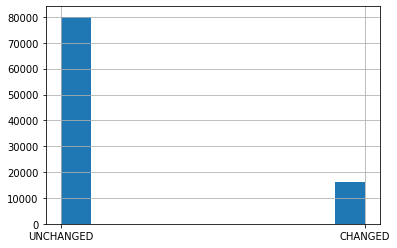

In [9]:
# The distribution of scope variable in the data used for modelling
merged_data_cleaned_v3["scope_v3"].hist()

# The unchanged class dominates the changed class in the scope. For simplcity, sampling to balance the classes is not
# investigated. In terms of specification, predicting the scope variable is a binary classification task.

confidentialityImpact_v3


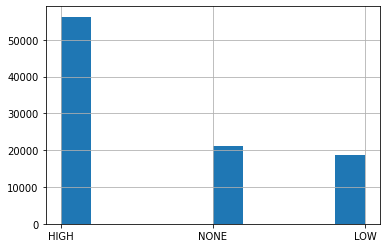

integrityImpact_v3


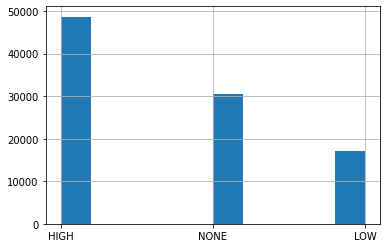

availabilityImpact_v3


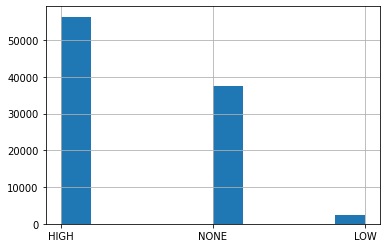

In [10]:
# The distribution of each of the impact metrics in the data used for modelling
for impact_metric in ["confidentialityImpact_v3", "integrityImpact_v3", "availabilityImpact_v3"]:
    print(impact_metric)
    merged_data_cleaned_v3[impact_metric].hist()
    plt.show()

### 2. Predicting scope

The scope metric is specific to v3. The attempt here is to use v2 metrics as well as the TF-IDF features from the description to develop a model to predict it. Here Random Forest is used as a baseline model to deal with correlated features.

In [11]:
# Consider the v2 CVSS metrics. Note that the vector string and base score are not used, as they carry the information, 
# already represented by the metrics values.

v2_metrics = ['accessVector_v2',
              'accessComplexity_v2',
              'authentication_v2',
              'confidentialityImpact_v2',
              'integrityImpact_v2',
              'availabilityImpact_v2']

In [12]:
# The initial split into train and test data allows to generate the test sets, where the final performance is validated.

feat_train, feat_test, y_train, y_test = \
    train_test_split(merged_data_cleaned_v3,
                     merged_data_cleaned_v3[["scope_v3",
                                             "confidentialityImpact_v3",
                                             "integrityImpact_v3",
                                             "availabilityImpact_v3"]],
                     shuffle = True,
                     test_size = .2, 
                     random_state=42)

In [13]:
# one hot encoder handles categorical features. Ignore the unseen tokens to handle new words in test data
ohe = OneHotEncoder(handle_unknown='ignore')

# vectoriser handles the natural text in description by extacting the tf-idf features
vectoriser = TfidfVectorizer(stop_words={"english"}, max_features = 500)

In [14]:
# preprocessor combines the operators above

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectoriser, "description"),
        ("cat", ohe, v2_metrics),
    ]
)

In [15]:
# the classifier used here (as discussed previously) is the Random Forest classifier

rf = RandomForestClassifier()

In [16]:
# clf object reprsents the pipeline that combines the preprocessing and modelling steps

clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", rf)]
)

In [17]:
# param_grid reprsents the parameter grid, where some of the key hyperparameters are explored. The list
# is non-exhaustive. The depth of a tree, number of trees and the class weighting are explored in random forest.
# Maximum features used in the TF-IDF vectorised are also explored.

param_grid = {
    "preprocessor__text__max_features": [250, 1000, 5000],
    "classifier__n_estimators": [20, 50, 100],
    "classifier__class_weight": ["balanced", None],
    "classifier__max_depth": [2, 5, 10]
}

In [18]:
# execute the parameter space exploration, where each step includes a 5 step Cross Validation
gs = GridSearchCV(clf, param_grid=param_grid, verbose = 4)
gs.fit(feat_train, y_train["scope_v3"])

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END classifier__class_weight=balanced, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=250;, score=0.933 total time=   3.4s
[CV 2/5] END classifier__class_weight=balanced, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=250;, score=0.899 total time=   3.5s
[CV 3/5] END classifier__class_weight=balanced, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=250;, score=0.937 total time=   3.4s
[CV 4/5] END classifier__class_weight=balanced, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=250;, score=0.902 total time=   3.4s
[CV 5/5] END classifier__class_weight=balanced, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=250;, score=0.930 total time=   3.4s
[CV 1/5] END classifier__class_weight=balanced, classifier__max_depth=2, class

[CV 4/5] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__n_estimators=20, preprocessor__text__max_features=250;, score=0.944 total time=   3.7s
[CV 5/5] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__n_estimators=20, preprocessor__text__max_features=250;, score=0.940 total time=   3.8s
[CV 1/5] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__n_estimators=20, preprocessor__text__max_features=1000;, score=0.915 total time=   3.6s
[CV 2/5] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__n_estimators=20, preprocessor__text__max_features=1000;, score=0.936 total time=   3.6s
[CV 3/5] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__n_estimators=20, preprocessor__text__max_features=1000;, score=0.930 total time=   3.6s
[CV 4/5] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__n_estimators=20, preprocessor__text__max_features=10

[CV 2/5] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=20, preprocessor__text__max_features=1000;, score=0.950 total time=   4.4s
[CV 3/5] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=20, preprocessor__text__max_features=1000;, score=0.954 total time=   4.4s
[CV 4/5] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=20, preprocessor__text__max_features=1000;, score=0.952 total time=   4.4s
[CV 5/5] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=20, preprocessor__text__max_features=1000;, score=0.948 total time=   4.4s
[CV 1/5] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=20, preprocessor__text__max_features=5000;, score=0.946 total time=   3.9s
[CV 2/5] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__n_estimators=20, preprocessor__text__max_fea

[CV 5/5] END classifier__class_weight=None, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=1000;, score=0.832 total time=   3.2s
[CV 1/5] END classifier__class_weight=None, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=5000;, score=0.832 total time=   3.1s
[CV 2/5] END classifier__class_weight=None, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=5000;, score=0.832 total time=   3.1s
[CV 3/5] END classifier__class_weight=None, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=5000;, score=0.832 total time=   3.1s
[CV 4/5] END classifier__class_weight=None, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=5000;, score=0.832 total time=   3.2s
[CV 5/5] END classifier__class_weight=None, classifier__max_depth=2, classifier__n_estimators=20, preprocessor__text__max_features=5000;, score=0.832 total

[CV 4/5] END classifier__class_weight=None, classifier__max_depth=5, classifier__n_estimators=20, preprocessor__text__max_features=5000;, score=0.877 total time=   3.3s
[CV 5/5] END classifier__class_weight=None, classifier__max_depth=5, classifier__n_estimators=20, preprocessor__text__max_features=5000;, score=0.858 total time=   3.3s
[CV 1/5] END classifier__class_weight=None, classifier__max_depth=5, classifier__n_estimators=50, preprocessor__text__max_features=250;, score=0.956 total time=   4.8s
[CV 2/5] END classifier__class_weight=None, classifier__max_depth=5, classifier__n_estimators=50, preprocessor__text__max_features=250;, score=0.951 total time=   4.7s
[CV 3/5] END classifier__class_weight=None, classifier__max_depth=5, classifier__n_estimators=50, preprocessor__text__max_features=250;, score=0.940 total time=   4.7s
[CV 4/5] END classifier__class_weight=None, classifier__max_depth=5, classifier__n_estimators=50, preprocessor__text__max_features=250;, score=0.943 total tim

[CV 3/5] END classifier__class_weight=None, classifier__max_depth=10, classifier__n_estimators=50, preprocessor__text__max_features=250;, score=0.959 total time=   7.6s
[CV 4/5] END classifier__class_weight=None, classifier__max_depth=10, classifier__n_estimators=50, preprocessor__text__max_features=250;, score=0.959 total time=   7.6s
[CV 5/5] END classifier__class_weight=None, classifier__max_depth=10, classifier__n_estimators=50, preprocessor__text__max_features=250;, score=0.959 total time=   7.5s
[CV 1/5] END classifier__class_weight=None, classifier__max_depth=10, classifier__n_estimators=50, preprocessor__text__max_features=1000;, score=0.957 total time=   6.1s
[CV 2/5] END classifier__class_weight=None, classifier__max_depth=10, classifier__n_estimators=50, preprocessor__text__max_features=1000;, score=0.955 total time=   6.1s
[CV 3/5] END classifier__class_weight=None, classifier__max_depth=10, classifier__n_estimators=50, preprocessor__text__max_features=1000;, score=0.960 to

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(max_features=500,
                                                                                         stop_words={'english'}),
                                                                         'description'),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['accessVector_v2',
                                                                          'accessComplexity_v2',
                                                                          'authentication_v2',
                                                                          '

In [19]:
gs.best_params_

{'classifier__class_weight': None,
 'classifier__max_depth': 10,
 'classifier__n_estimators': 100,
 'preprocessor__text__max_features': 250}

In [20]:
# re-train model on the full train data

scope_predictor = gs.best_estimator_
scope_predictor.fit(feat_train, y_train["scope_v3"])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=250,
                                                                  stop_words={'english'}),
                                                  'description'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['accessVector_v2',
                                                   'accessComplexity_v2',
                                                   'authentication_v2',
                                                   'confidentialityImpact_v2',
                                                   'integrityImpact_v2',
                                                   'availabilityImpact_v2'])])),
                ('classifier', RandomForestClassifier(max_depth=10))])

In [21]:
# Consider precision and recall metrics on the train data, with respect to the CHANGED and UNCHANGED classes. 
# If needed, the amount of false negatoves, with respect to the CHANGED class, could be improved at the expense of
# increasing the amount of false positives and decreasing recall.

print(classification_report(y_train["scope_v3"], scope_predictor.predict(feat_train)))

              precision    recall  f1-score   support

     CHANGED       0.99      0.77      0.87     12969
   UNCHANGED       0.96      1.00      0.98     64059

    accuracy                           0.96     77028
   macro avg       0.97      0.89      0.92     77028
weighted avg       0.96      0.96      0.96     77028



In [22]:
# Consider precision and recall metrics on the test data, with respect to the CHANGED and UNCHANGED classes. 

print(classification_report(y_test["scope_v3"], scope_predictor.predict(feat_test)))

# The performance on train and test data is quite similar, indicaing, there is likely little overfitting.

              precision    recall  f1-score   support

     CHANGED       0.99      0.76      0.86      3230
   UNCHANGED       0.95      1.00      0.98     16028

    accuracy                           0.96     19258
   macro avg       0.97      0.88      0.92     19258
weighted avg       0.96      0.96      0.96     19258



In [23]:
# save the model
dump(scope_predictor, "models/scope_predictor.joblib")

['models/scope_predictor.joblib']

In [24]:
# make predictions on unseen v2 only data
scope_predictions = scope_predictor.predict(merged_data_cleaned_no_v3)

In [25]:
# store predictions
pd.DataFrame({"cve_id": merged_data_cleaned_no_v3.cve_id,
             "scope_v3_prediction": scope_predictions}).to_csv("predictions/scope_predictions.csv")

### 3. Predicting impact metrics

From the CVSS documentation, as well as the talk on CVSS: https://www.youtube.com/watch?v=vTA3K1riS6E, the v3 impact metrics seem to loosely follow the following relationship with v2 features and scope.

- The v3 impact metric value is **LOW** if there is Partial loss (v2) without direct, serious impact on affected scope.

- The v3 impact metric value is **HIGH** if there is complete loss (v2) or there is partial loss (v2) without direct, serious impact on affected scope.

This, however, is not reflected clearly in the data:

In [26]:
# Consider the following example, where the largest group the availabilityImpact_v3 takes value HIGH (the scope is
# UNCHANGED) and availabilityImpact_v2 is PARTIAL

merged_data_cleaned_v3.groupby(["scope_v3", "availabilityImpact_v3"])["availabilityImpact_v2"].value_counts()

scope_v3   availabilityImpact_v3  availabilityImpact_v2
CHANGED    HIGH                   PARTIAL                   1185
                                  COMPLETE                  1082
                                  NONE                        30
           LOW                    PARTIAL                    240
                                  NONE                        19
           NONE                   NONE                     13615
                                  PARTIAL                     26
                                  COMPLETE                     2
UNCHANGED  HIGH                   PARTIAL                  36273
                                  COMPLETE                 16529
                                  NONE                      1279
           LOW                    PARTIAL                   2075
                                  NONE                        52
                                  COMPLETE                     4
           NONE                   

Nevertheless a rule based approach can be attempted. Using a predicted value of Scope_v3, one can approximate the value of an impact metric.

In [27]:
from typing import Tuple

class RuleBasedClassifer(BaseEstimator):
    
    def __init__(self, feature_name: str, scope_prediction_name: str):
        self.feature_name = feature_name
        self.scope_prediction_name = scope_prediction_name
    
    def fit(self, X: pd.DataFrame, y: pd.Series) : pass
        
    def predict(self, X: pd.DataFrame) -> Tuple:
        """
        Make prediction based on rules
        
        :params X:
        """
        return X.apply(lambda row: self._map_to_metric(row), axis = 1)
    
    def _map_to_metric(self, row: pd.Series) -> str:
        """
        Contains the logic of how the prediction is made.
        
        :params row: Tuple
         """
        
        if (row[self.feature_name] == "COMPLETE") or (row[self.scope_prediction_name] == "CHANGED") and (row[self.feature_name] == "PARTIAL"):
            return "HIGH"
        
        elif (row["scope_v3"] == "UNCHANGED") and (row[self.feature_name] == "PARTIAL"):
            return "LOW"
        
        else:
            return "NONE"
        

In [28]:
# add scope predictions to the train and test data for simplicity
scope_prediction_var = "scope_prediction"
feat_train[scope_prediction_var] = scope_predictor.predict(feat_train)
feat_test[scope_prediction_var] = scope_predictor.predict(feat_test)

In [29]:
# let us evaluate the performance of the rule based classifier on test data for availabilityImpact_v3. There are
# large amounts of false negatives in the HIGH class, which reflects the mismatch between rules and data, outlined before

rbc = RuleBasedClassifer(feature_name = 'availabilityImpact_v2', scope_prediction_name=scope_prediction_var)
print(classification_report(y_train['availabilityImpact_v3'], rbc.predict(feat_train)))
print(classification_report(y_test['availabilityImpact_v3'], rbc.predict(feat_test)))

              precision    recall  f1-score   support

        HIGH       0.99      0.32      0.48     45120
         LOW       0.05      0.87      0.10      1918
        NONE       0.94      0.98      0.96     29990

    accuracy                           0.59     77028
   macro avg       0.66      0.72      0.51     77028
weighted avg       0.95      0.59      0.66     77028

              precision    recall  f1-score   support

        HIGH       0.99      0.31      0.48     11269
         LOW       0.05      0.86      0.10       472
        NONE       0.93      0.98      0.96      7517

    accuracy                           0.59     19258
   macro avg       0.66      0.72      0.51     19258
weighted avg       0.95      0.59      0.66     19258



Let us try an approach, similar to scope prediction, where the text description and v2 features are used to improve the model performance (for simplicity we use the same optimal parameters as before, however this could be improved in further iterations):

In [30]:
class PipelineFactory:
    """
    Generate models, predicting impact metrics, similar to the one used for scope
    """
    def __init__(self, categorical_feats: List[str], text_feature: str):
        self.categorical_feats = categorical_feats
        self.text_feature = text_feature
        
    def generate_pipeline(self, target_name: str) -> Pipeline:
        """
        Generate a pipeline to predict a target.
        The hyperparameters are taken from before for simplicity.
        Note the optimal hyperparameters may vary depending on the run (e.g. if new data is available)
        """
        ohe = OneHotEncoder(handle_unknown='ignore')
        vectoriser = TfidfVectorizer(stop_words={"english"}, max_features = 250)
        rf = RandomForestClassifier(n_estimators=100, max_depth=10)
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("text", vectoriser, self.text_feature),
                ("cat", ohe, self.categorical_feats)
            ])
        
        
        clf = Pipeline(
            steps=[("preprocessor", preprocessor),
           ("classifier", rf)])
        
        return clf
    
    def generate_pipelines(self, targets: List[str]) -> Dict[str, Pipeline]:
        """
        Generate multiple pipelines based on targets
        """
        return {target: self.generate_pipeline(target) for target in targets}


In [31]:
targets = ['confidentialityImpact_v3', 'integrityImpact_v3','availabilityImpact_v3']

In [32]:
ppf = PipelineFactory(categorical_feats=v2_metrics, text_feature='description')

In [33]:
predictor_pipelines = ppf.generate_pipelines(targets)

In [34]:
# train the models
for target, pp in predictor_pipelines.items():
    print(f"Training {target}_predictor")
    pp.fit(feat_train, y_train[target])

Training confidentialityImpact_v3_predictor
Training integrityImpact_v3_predictor
Training availabilityImpact_v3_predictor


In [35]:
# evaluate performance
for target, pp in predictor_pipelines.items():
    print(target)
    print("Train performance")
    print(classification_report(y_train[target], pp.predict(feat_train)))
    print("Test performance")
    print(classification_report(y_test[target], pp.predict(feat_test)))
    
# The performance is better than that of the rule based approach. There is, however a large number of false 
# negatives predicted in availabilityImpact_v3, which could be explained by the small number of LOW samples

confidentialityImpact_v3
Train performance
              precision    recall  f1-score   support

        HIGH       0.90      1.00      0.95     45020
         LOW       0.97      0.66      0.79     15006
        NONE       0.99      0.98      0.99     17002

    accuracy                           0.93     77028
   macro avg       0.95      0.88      0.91     77028
weighted avg       0.93      0.93      0.92     77028

Test performance
              precision    recall  f1-score   support

        HIGH       0.90      1.00      0.94     11272
         LOW       0.96      0.65      0.77      3738
        NONE       0.99      0.98      0.98      4248

    accuracy                           0.92     19258
   macro avg       0.95      0.87      0.90     19258
weighted avg       0.93      0.92      0.92     19258

integrityImpact_v3
Train performance
              precision    recall  f1-score   support

        HIGH       0.94      0.95      0.94     38958
         LOW       0.92      0.8

In [36]:
# store models
for feat, pp in predictor_pipelines.items():
    logging.info("Saving model")
    dump(pp, f"models/{feat}_predictor.joblib")

INFO:root:Saving model
INFO:root:Saving model
INFO:root:Saving model


In [37]:
# make predictions on unseen v2 only data and store
for target, pp in predictor_pipelines.items():
    print(target)
    print("Making predictions on unseen v2 only data")
    predictions = pp.predict(merged_data_cleaned_no_v3)
    pd.DataFrame({"cve_id": merged_data_cleaned_no_v3.cve_id,
             f"{target}_prediction": predictions}).to_csv(f"predictions/{target}_predictions.csv")

confidentialityImpact_v3
Making predictions on unseen v2 only data
integrityImpact_v3
Making predictions on unseen v2 only data
availabilityImpact_v3
Making predictions on unseen v2 only data
